In [1]:
import sympy
sympy.init_printing()

In [2]:
# DH 파라미터를 이용해 Homogeneous Transformation Matrix 만드는 함수
def DH(a, alpha, d, theta):
    T_rot_x = sympy.Matrix([[1,0,0,0],
                            [0,sympy.cos(alpha),-sympy.sin(alpha),0],
                            [0,sympy.sin(alpha),sympy.cos(alpha),0],
                            [0,0,0,1]]);
    T_trans_x = sympy.Matrix([[1,0,0,a],
                              [0,1,0,0],
                              [0,0,1,0],
                              [0,0,0,1]]);
    T_trans_z = sympy.Matrix([[1,0,0,0],
                              [0,1,0,0],
                              [0,0,1,d],
                              [0,0,0,1]]);
    T_rot_z = sympy.Matrix([[sympy.cos(theta),-sympy.sin(theta),0,0],
                            [sympy.sin(theta),sympy.cos(theta),0,0],
                            [0,0,1,0],
                            [0,0,0,1]]);
    T = T_rot_x*T_trans_x*T_trans_z*T_rot_z;
    return T

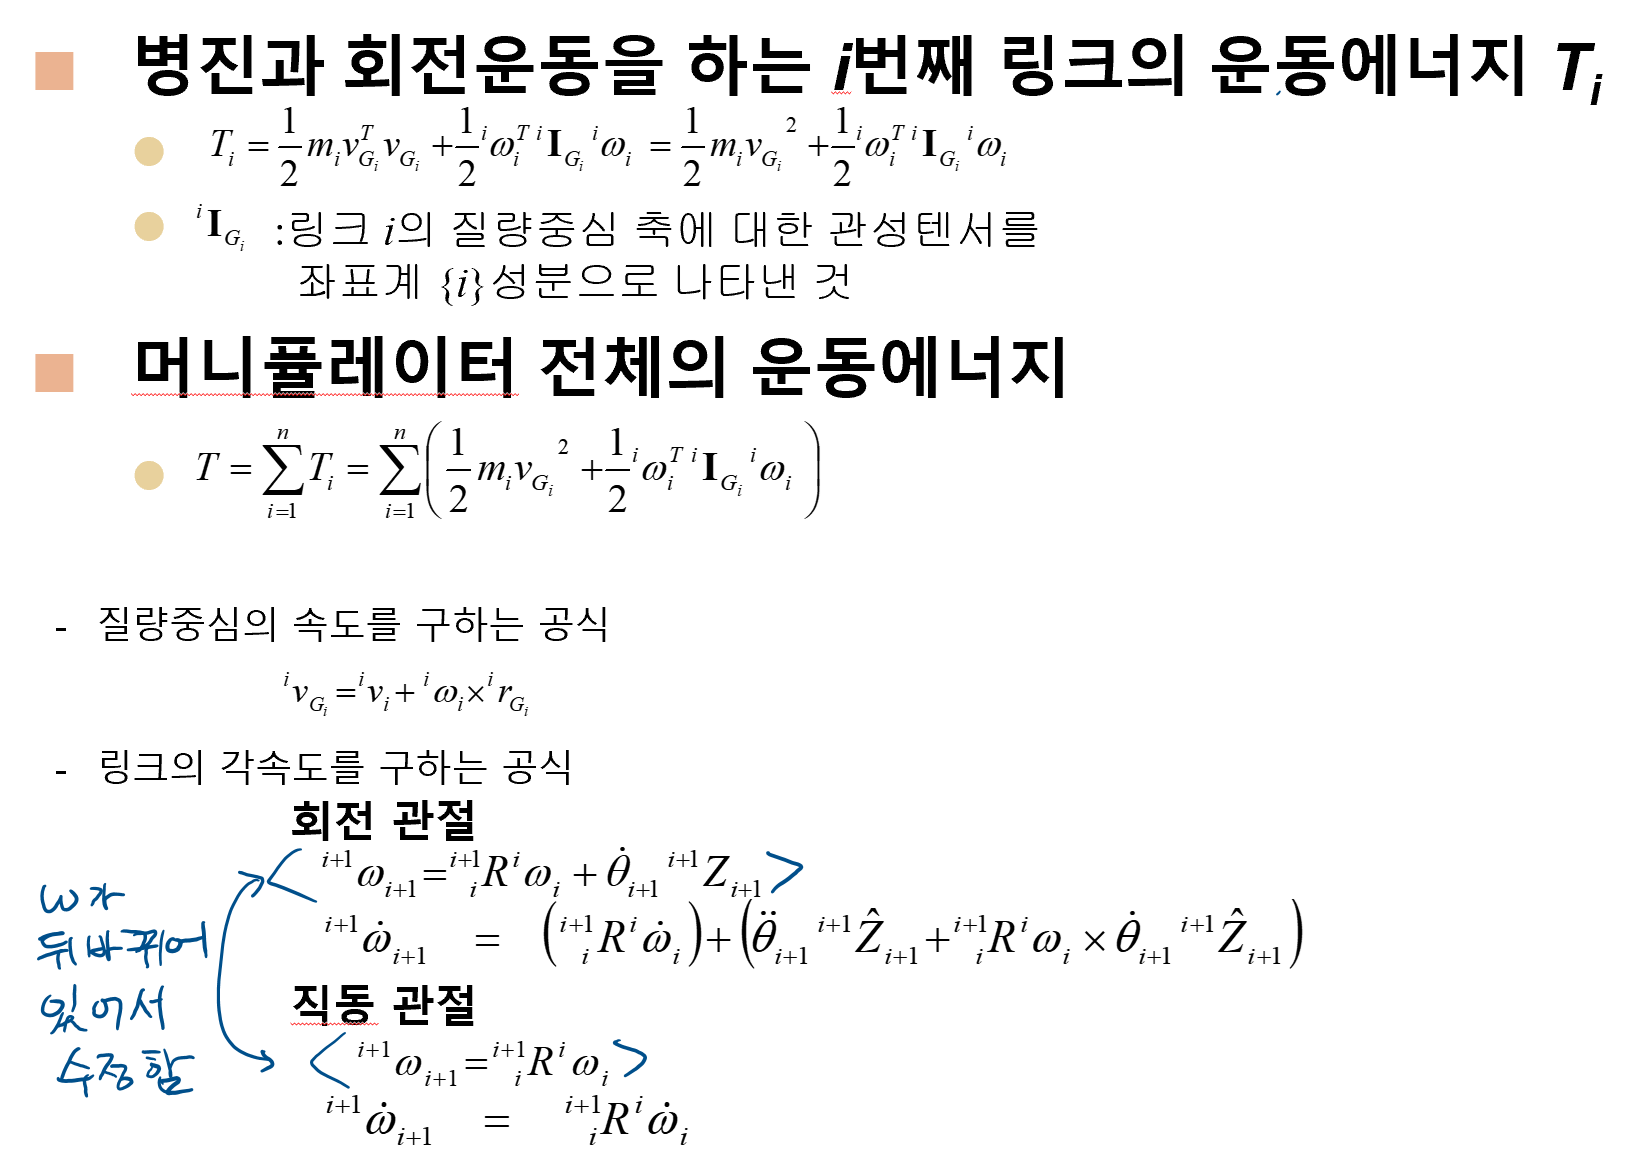

In [3]:
from IPython.display import Image
Image('T구하는공식.PNG', width=500)

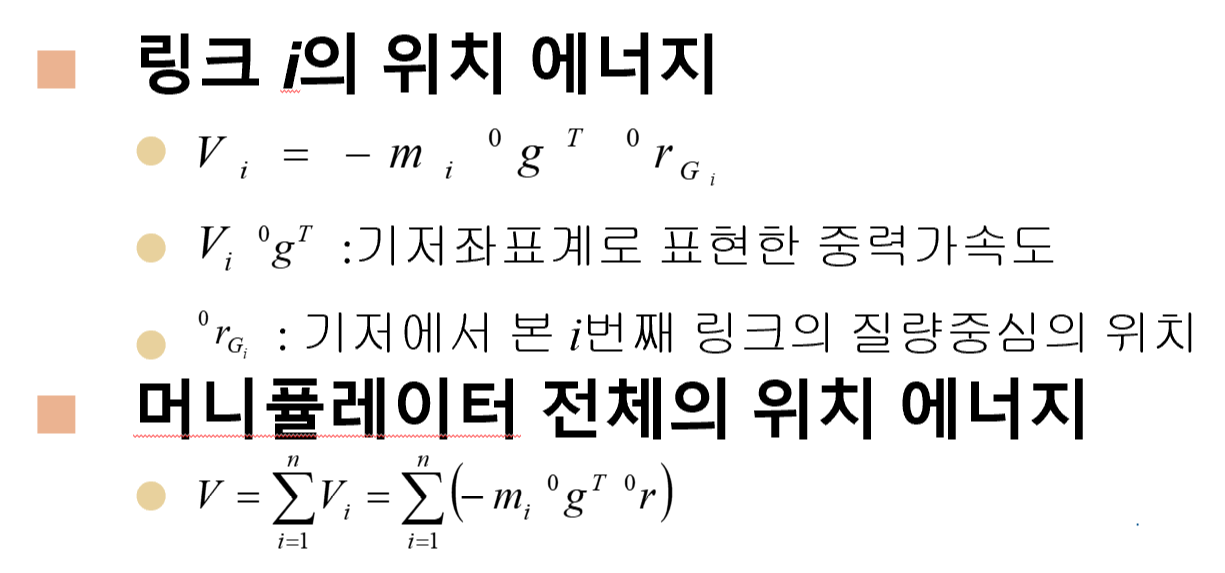

In [4]:
from IPython.display import Image
Image('V구하는공식.PNG', width=300)

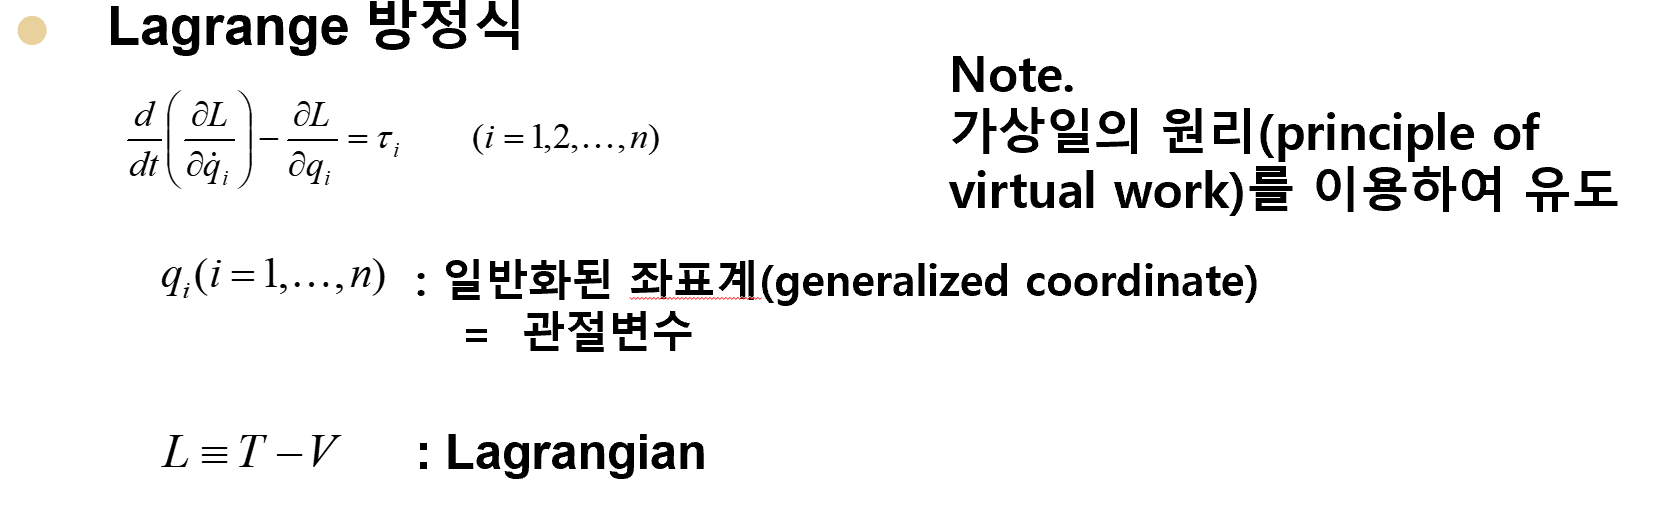

In [5]:
from IPython.display import Image
Image('L구하는공식.PNG', width=500)

In [6]:
###### 동역학 공식
# 동차변환에서 회전행렬만 뽑아내는 함수
def get_R_from_T(T):
    R = T[0:3,0:3];
    return R

# 동차변환에서 위치백터만 뽑아내는 함수
def get_P_from_T(T):
    P = T[0:3,3];
    return P

###### 운동에너지 T 구하는 부분
### 회전관절
# 속도전파식을 이용하여 각속도를 구하는 함수
def get_angular_vel_R(T_i_ip1,w_i_i,thd_ip1):
    R_i_ip1 = get_R_from_T(T_i_ip1);
    R_ip1_i = sympy.transpose(R_i_ip1);
    Z_ip1_ip1 = sympy.Matrix([[0],[0],[1]]);
    w_ip1_ip1 = R_ip1_i@w_i_i + thd_ip1*Z_ip1_ip1;
    return w_ip1_ip1    

# 속도전파식을 이용하여 선속도를 구하는 함수
def get_linear_vel_R(T_i_ip1,w_i,v_i):
    R_i_ip1 = get_R_from_T(T_i_ip1);
    R_ip1_i = sympy.transpose(R_i_ip1);
    r_i_ip1 = T_i_ip1[0:3,3:4];
    v_ip1_ip1 = R_ip1_i@(v_i + w_i.cross(r_i_ip1));
    return v_ip1_ip1

### 직동관절
# 속도전파식을 이용하여 각속도를 구하는 함수
def get_angular_vel_P(T_i_ip1,w_i_i):
    R_i_ip1 = get_R_from_T(T_i_ip1);
    R_ip1_i = sympy.transpose(R_i_ip1);
    w_ip1_ip1 = R_ip1_i@w_i_i;
    return w_ip1_ip1

# 속도전파식을 이용하여 선속도를 구하는 함수
def get_linear_vel_P(T_i_ip1,w_i_i,v_i_i,dd_ip1):
    R_i_ip1 = get_R_from_T(T_i_ip1);
    R_ip1_i = sympy.transpose(R_i_ip1);
    r_i_ip1 = T_i_ip1[0:3,3:4];
    Z_ip1_ip1 = sympy.Matrix([[0],[0],[1]]);
    v_ip1_ip1 = R_ip1_i@(v_i_i + w_i_i.cross(r_i_ip1)) + dd_ip1*Z_ip1_ip1;
    return v_ip1_ip1

# 질량중심의 속도 구하는 함수
def get_com_vel(v_i_i,w_i_i,r_i_Gi):
    v_i_Gi = v_i_i +  w_i_i.cross(r_i_Gi);
    return v_i_Gi

# T 구하는 함수
def get_kinectic_energy(m_i,v_i_Gi,I_i_Gi,w_i_i):
    T = 1/2*m_i*v_i_Gi.T@v_i_Gi + 1/2*w_i_i.T*I_i_Gi*w_i_i;
    return T

###### 위치에너지 V를 구하는 함수
def get_potential_energy(T_0_i,m_i,g_0,r_i_Gi):
    r_0_i = T_0_i[0:3,3:4];
    R_0_i = get_R_from_T(T_0_i);
    r_0_Gi = r_0_i + R_0_i@r_i_Gi;
    V = -m_i*g_0.T@r_0_Gi;
    return V

###### 라그랑지안 L 구하는 함수
def get_lagrangian(T,V):
    L = T - V;
    return L

def get_torque_from_L(L,q,qd):
    round_L_round_q = sympy.zeros(len(q),1);
    i = 0;
    for q_i in q:
        round_L_round_q_i = [];
        round_L_round_q_i = sympy.simplify(sympy.diff(L,q_i));
        round_L_round_q[i] = sympy.Matrix(round_L_round_q_i);
        i+=1;
     
    d_dt_round_L_round_qd = sympy.zeros(len(qd),1);
    i = 0;
    for qd_i in qd:
        round_L_round_qd_i = [];
        d_dt_round_L_round_qd_i = [];
        round_L_round_qd_i = sympy.diff(L,qd_i);
        d_dt_round_L_round_qd_i = sympy.simplify(time_derivative(round_L_round_qd_i,N));
        d_dt_round_L_round_qd[i] = sympy.Matrix(d_dt_round_L_round_qd_i);
        i+=1;
        
    tau = d_dt_round_L_round_qd - round_L_round_q 
    return tau

###### 머니퓰레이터 운동방적식
def get_EoM_from_T(tau,qdd,g):
    # Inertia Matrix, M(q)를 구해주는 부분
    M = sympy.zeros(len(tau));
    i = 0;
    for tau_i in tau:
        M_i = [];
        M_i.append(sympy.simplify(sympy.diff(tau_i,qdd)));
        M[:,i] = sympy.Matrix(M_i);
        i+=1;

    # Gravity Matrix, G(q) 를 구해주는 부분
    G = sympy.zeros(len(tau),1);
    i = 0;
    for tau_i in tau:
        G_i = [];
        G_i.append(sympy.simplify(sympy.diff(tau_i,g)));
        G[i] = sympy.Matrix(G_i);
        i+=1;
        
    # 원심력 & 코리올리스 행렬, C(q,qd) 를 구해주는 부분
    C = sympy.simplify(tau - M@qdd - G*g);
    
    return M, C, G*g

## 연습문제 5-3

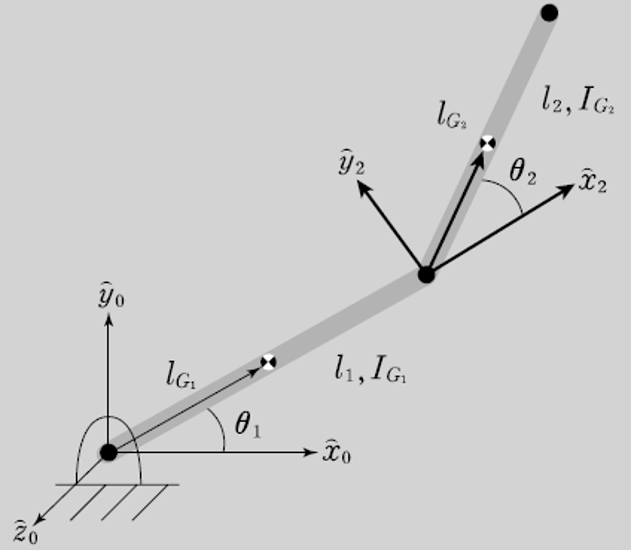

In [7]:
from IPython.display import Image
Image('예제5.2.PNG', width=300)

In [8]:
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
th1 = dynamicsymbols('th1')
th2 = dynamicsymbols('th2')

In [9]:
L1,LG1,L2,LG2,IG1,IG2,m1,m2 = sympy.symbols('L1,LG1,L2,LG2,IG1,IG2,m1,m2')

In [10]:
# DH Parameter

In [11]:
T01 = DH(0,0,0,th1)

In [12]:
T12 = DH(L1,0,0,th2)

In [13]:
T23 = DH(L2,0,0,0)

In [14]:
T01, T12, T23

⎛⎡cos(th₁(t))  -sin(th₁(t))  0  0⎤  ⎡cos(th₂(t))  -sin(th₂(t))  0  L₁⎤  ⎡1  0 
⎜⎢                               ⎥  ⎢                                ⎥  ⎢     
⎜⎢sin(th₁(t))  cos(th₁(t))   0  0⎥  ⎢sin(th₂(t))  cos(th₂(t))   0  0 ⎥  ⎢0  1 
⎜⎢                               ⎥, ⎢                                ⎥, ⎢     
⎜⎢     0            0        1  0⎥  ⎢     0            0        1  0 ⎥  ⎢0  0 
⎜⎢                               ⎥  ⎢                                ⎥  ⎢     
⎝⎣     0            0        0  1⎦  ⎣     0            0        0  1 ⎦  ⎣0  0 

 0  L₂⎤⎞
      ⎥⎟
 0  0 ⎥⎟
      ⎥⎟
 1  0 ⎥⎟
      ⎥⎟
 0  1 ⎦⎠

In [15]:
T03 = sympy.simplify(T01*T12*T23)

In [16]:
T03

⎡cos(th₁(t) + th₂(t))  -sin(th₁(t) + th₂(t))  0  L₁⋅cos(th₁(t)) + L₂⋅cos(th₁(t
⎢                                                                             
⎢sin(th₁(t) + th₂(t))  cos(th₁(t) + th₂(t))   0  L₁⋅sin(th₁(t)) + L₂⋅sin(th₁(t
⎢                                                                             
⎢         0                      0            1                     0         
⎢                                                                             
⎣         0                      0            0                     1         

) + th₂(t))⎤
           ⎥
) + th₂(t))⎥
           ⎥
           ⎥
           ⎥
           ⎦

In [17]:
# 운동에너지 구하기

In [18]:
w_0_0 = sympy.Matrix([[0],[0],[0]])
w_1_1 = get_angular_vel_R(T01,w_0_0,th1.diff())
w_2_2 = get_angular_vel_R(T12,w_1_1,th2.diff())

In [19]:
w_1_1,w_2_2

⎛⎡    0     ⎤  ⎡           0           ⎤⎞
⎜⎢          ⎥  ⎢                       ⎥⎟
⎜⎢    0     ⎥  ⎢           0           ⎥⎟
⎜⎢          ⎥, ⎢                       ⎥⎟
⎜⎢d         ⎥  ⎢d            d         ⎥⎟
⎜⎢──(th₁(t))⎥  ⎢──(th₁(t)) + ──(th₂(t))⎥⎟
⎝⎣dt        ⎦  ⎣dt           dt        ⎦⎠

In [20]:
v_0_0 = sympy.Matrix([[0],[0],[0]])
v_1_1 = get_linear_vel_R(T01,w_0_0,v_0_0)
v_2_2 = get_linear_vel_R(T12,w_1_1,v_1_1)

In [21]:
v_1_1,v_2_2

⎛     ⎡               d         ⎤⎞
⎜     ⎢L₁⋅sin(th₂(t))⋅──(th₁(t))⎥⎟
⎜⎡0⎤  ⎢               dt        ⎥⎟
⎜⎢ ⎥  ⎢                         ⎥⎟
⎜⎢0⎥, ⎢               d         ⎥⎟
⎜⎢ ⎥  ⎢L₁⋅cos(th₂(t))⋅──(th₁(t))⎥⎟
⎜⎣0⎦  ⎢               dt        ⎥⎟
⎜     ⎢                         ⎥⎟
⎝     ⎣            0            ⎦⎠

In [22]:
r_1_G1 = sympy.Matrix([[LG1],[0],[0]])
r_2_G2 = sympy.Matrix([[LG2],[0],[0]])
v_1_G1 = get_com_vel(v_1_1,w_1_1,r_1_G1)
v_2_G2 = get_com_vel(v_2_2,w_2_2,r_2_G2)

In [23]:
v_1_G1, v_2_G2

⎛                  ⎡                               d                         ⎤
⎜⎡      0       ⎤  ⎢                L₁⋅sin(th₂(t))⋅──(th₁(t))                ⎥
⎜⎢              ⎥  ⎢                               dt                        ⎥
⎜⎢    d         ⎥  ⎢                                                         ⎥
⎜⎢LG₁⋅──(th₁(t))⎥, ⎢               d                ⎛d            d         ⎞⎥
⎜⎢    dt        ⎥  ⎢L₁⋅cos(th₂(t))⋅──(th₁(t)) + LG₂⋅⎜──(th₁(t)) + ──(th₂(t))⎟⎥
⎜⎢              ⎥  ⎢               dt               ⎝dt           dt        ⎠⎥
⎜⎣      0       ⎦  ⎢                                                         ⎥
⎝                  ⎣                            0                            ⎦

⎞
⎟
⎟
⎟
⎟
⎟
⎟
⎟
⎠

In [24]:
# 운동에너지
Ixx1,Iyy1,Izz1,Ixx2,Iyy2,Izz2 = sympy.symbols('Ixx1,Iyy1,Izz1,Ixx2,Iyy2,Izz2')
I_1_G1 = sympy.Matrix([[Ixx1,0,0],[0,Iyy1,0],[0,0,Izz1]])
I_2_G2 = sympy.Matrix([[Ixx2,0,0],[0,Iyy2,0],[0,0,Izz2]])
T = get_kinectic_energy(m1,v_1_G1,I_1_G1,w_1_1) + get_kinectic_energy(m2,v_2_G2,I_2_G2,w_2_2)

In [25]:
T

⎡                     2                                                       
⎢         ⎛d         ⎞         ⎛    d                d         ⎞ ⎛d           
⎢0.5⋅Izz₁⋅⎜──(th₁(t))⎟  + Izz₂⋅⎜0.5⋅──(th₁(t)) + 0.5⋅──(th₂(t))⎟⋅⎜──(th₁(t)) +
⎣         ⎝dt        ⎠         ⎝    dt               dt        ⎠ ⎝dt          

                                                   2                          
 d         ⎞         2       2         ⎛d         ⎞           2    ⎛d         
 ──(th₂(t))⎟ + 0.5⋅L₁ ⋅m₂⋅sin (th₂(t))⋅⎜──(th₁(t))⎟  + 0.5⋅LG₁ ⋅m₁⋅⎜──(th₁(t))
 dt        ⎠                           ⎝dt        ⎠                ⎝dt        

 2                                                                     2⎤
⎞           ⎛               d                ⎛d            d         ⎞⎞ ⎥
⎟  + 0.5⋅m₂⋅⎜L₁⋅cos(th₂(t))⋅──(th₁(t)) + LG₂⋅⎜──(th₁(t)) + ──(th₂(t))⎟⎟ ⎥
⎠           ⎝               dt               ⎝dt           dt        ⎠⎠ ⎦

In [26]:
# 위치에너지 구하기

In [27]:
g = sympy.symbols('g')

In [28]:
g_0 = sympy.Matrix([[0],[-g],[0]])

In [29]:
T02 = T01*T12
V = get_potential_energy(T01,m1,g_0,r_1_G1) + get_potential_energy(T02,m2,g_0,r_2_G2)

In [30]:
V

[LG₁⋅g⋅m₁⋅sin(th₁(t)) + g⋅m₂⋅(L₁⋅sin(th₁(t)) + LG₂⋅(sin(th₁(t))⋅cos(th₂(t)) + 
sin(th₂(t))⋅cos(th₁(t))))]

In [31]:
# 라그랑지안 구하기
L = get_lagrangian(T,V)

In [32]:
L

⎡                     2                                                       
⎢         ⎛d         ⎞         ⎛    d                d         ⎞ ⎛d           
⎢0.5⋅Izz₁⋅⎜──(th₁(t))⎟  + Izz₂⋅⎜0.5⋅──(th₁(t)) + 0.5⋅──(th₂(t))⎟⋅⎜──(th₁(t)) +
⎣         ⎝dt        ⎠         ⎝    dt               dt        ⎠ ⎝dt          

                                                   2                          
 d         ⎞         2       2         ⎛d         ⎞           2    ⎛d         
 ──(th₂(t))⎟ + 0.5⋅L₁ ⋅m₂⋅sin (th₂(t))⋅⎜──(th₁(t))⎟  + 0.5⋅LG₁ ⋅m₁⋅⎜──(th₁(t))
 dt        ⎠                           ⎝dt        ⎠                ⎝dt        

 2                                                                            
⎞                                                                             
⎟  - LG₁⋅g⋅m₁⋅sin(th₁(t)) - g⋅m₂⋅(L₁⋅sin(th₁(t)) + LG₂⋅(sin(th₁(t))⋅cos(th₂(t)
⎠                                                                             

                                                 

In [33]:
q = sympy.Matrix([[th1],[th2]])
qd = sympy.Matrix([[th1.diff()],[th2.diff()]])
tau = get_torque_from_L(L,q,qd)

In [34]:
# Get Equation of Motion

In [35]:
tau

⎡           2                      2                      2                   
⎢          d                      d                      d                  2 
⎢1.0⋅Izz₁⋅───(th₁(t)) + 1.0⋅Izz₂⋅───(th₁(t)) + 1.0⋅Izz₂⋅───(th₂(t)) + 1.0⋅L₁ ⋅
⎢           2                      2                      2                   
⎢         dt                     dt                     dt                    
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

     2                                                                        
    d                                      d       

In [36]:
qdd = sympy.Matrix([[th1.diff().diff()],[th2.diff().diff()]])
M_, C_, G_ = get_EoM_from_T(tau,qdd,g)

In [37]:
M_

⎡                            2                                         2      
⎢1.0⋅Izz₁ + 1.0⋅Izz₂ + 1.0⋅L₁ ⋅m₂ + 2.0⋅L₁⋅LG₂⋅m₂⋅cos(th₂(t)) + 1.0⋅LG₁ ⋅m₁ + 
⎢                                                                             
⎢                                                                 2           
⎣                   1.0⋅Izz₂ + 1.0⋅L₁⋅LG₂⋅m₂⋅cos(th₂(t)) + 1.0⋅LG₂ ⋅m₂        

       2                                                 ⎤
1.0⋅LG₂ ⋅m₂  1.0⋅Izz₂ + 1.0⋅LG₂⋅m₂⋅(L₁⋅cos(th₂(t)) + LG₂)⎥
                                                         ⎥
                                          2              ⎥
                        1.0⋅Izz₂ + 1.0⋅LG₂ ⋅m₂           ⎦

In [38]:
C_

⎡           ⎛    d                d         ⎞             d         ⎤
⎢-L₁⋅LG₂⋅m₂⋅⎜2.0⋅──(th₁(t)) + 1.0⋅──(th₂(t))⎟⋅sin(th₂(t))⋅──(th₂(t))⎥
⎢           ⎝    dt               dt        ⎠             dt        ⎥
⎢                                                                   ⎥
⎢                                                    2              ⎥
⎢                                        ⎛d         ⎞               ⎥
⎢              1.0⋅L₁⋅LG₂⋅m₂⋅sin(th₂(t))⋅⎜──(th₁(t))⎟               ⎥
⎣                                        ⎝dt        ⎠               ⎦

In [39]:
G_

⎡g⋅(L₁⋅m₂⋅cos(th₁(t)) + LG₁⋅m₁⋅cos(th₁(t)) + LG₂⋅m₂⋅cos(th₁(t) + th₂(t)))⎤
⎢                                                                        ⎥
⎣                   1.0⋅LG₂⋅g⋅m₂⋅cos(th₁(t) + th₂(t))                    ⎦